**This notebook is *not* the report: that is `report.pdf`.  This notebook performs the analysis tasks, but the formal write-up is in `report.pdf`.  Please treat the "markdown" parts of this document as just fancy "code comments" explaining how the analysis code works. :)**

In [1]:
# Required Packages
import pandas as pd # I hope pandas is ok!
import numpy as np
import matplotlib.pyplot as plt
import os

# need to get some lists and variables that I have stored in setup.py
# see setup.py for descriptions of each variable
from setup import years, months, mcu_folder, comics_folder

# a "look up table" that lets you get a string for of a month
# given its number index
month_string = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}

### Comment out these lines if you don't have a LaTeX distribution installed!
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=9) # use a nice TeX serif font

plt.rcParams["figure.figsize"] = (5, 3.75) # make default figure size smaller

# Make sure that we have pdf graphics in the exported notebook
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# Data Wrangling
The comic book data is in the form of many data files.  Each corresponds to a year and a month, and each has sales data for all the comic books released that month.  We need to add get onlly the ones from published by Marvel for each month, and add them all up.

In [2]:
# initialize an empty list
marvel_comics = []

# go through every data file
for filename in os.listdir(comics_folder):
    
    # open the data
    data = pd.read_csv(comics_folder + "/" + filename)
    
    # get only the data corresponding to comics published by Marvel
    data = data[data["publisher"] == "Marvel"]
    
    # compute the earnings by multiplying price by units sold
    data["earnings"] = data["price"] * data["units"]
    
    # compute the montly sum
    total = np.sum(data["earnings"])
    
    # place into the list
    marvel_comics.append(total)

# convert to numpy array to be safe
marvel_comics = np.array(marvel_comics)

The mcu data folder features a dataset for each mcu film.  Each dataset has daily box office numbers for the film.  We need to go through all the months from 2008 to 2019 and add up the total earnings of all mcu movies in that month.

In [3]:
# initalize a storage list
mcu = []

# go through ever year (2008-2019 inclusive)
for year in years:
    # go through months from 1 to 12
    for month in months:
        
        # get the "string form" of the month by looking it
        # up in the table defined in an above code cell
        m = month_string[month]
        
        # initalize the total mcu earnings for this month and year
        total = 0
        
        # go through every file in the mcu folder
        for filename in os.listdir(mcu_folder):
            
            # read the file into a pandas dataframe
            data = pd.read_csv(mcu_folder + "/" + filename)
            
            # go through every row of the dataframe (effectively, this
            # goes through every day since the release of the movie)
            for i in range(len(data["date"])):
                
                # check if the data corresponds to the month and year
                # we are currently working on
                if m in data["date"][i] and str(year) in data["date"][i]:
                    
                    # if so, add the earnings of this movie at this date to
                    # the total
                    total += float(data["earnings"][i])
        # place the total earnings into the storage array            
        mcu.append(total)
# convert to numpy array
mcu = np.array(mcu)

# Analysis
First, plot both datasets: the total marvel comics earnings and mcu movie earnings.

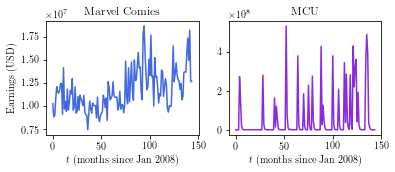

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (5.6, 2.5))
ax1, ax2 = axes

ax1.plot(marvel_comics, color = "royalblue")
ax1.set_title("Marvel Comics")
ax1.set_ylabel("Earnings (USD)")

for ax in axes:
    ax.set_xlabel("$t$ (months since Jan 2008)")


ax2.plot(mcu, color = "blueviolet")
ax2.set_title("MCU")
plt.tight_layout()
plt.savefig("figures/raw_data1.pdf")
plt.show()

Now define our cross-correlation function from Lab 04:

In [5]:
def CC(f, g, dt = 1.0):
    """
    (STOLEN FROM MY CODE FOR LAB 03)
    quick helper functions to compute the cross correlation
    between two time series 
    
    Params
    ------------
    f, g: time series (array)
    dt: sampling interval (float)
    
    Returns
    ------------
    c: array, crosscorrelation of f and g
    """
    # Pad with N - 1 zeros as suggested by the lab sheet
    f = np.concatenate((f, np.zeros(len(f) - 1, dtype = complex)))
    g = np.concatenate((g, np.zeros(len(g) - 1, dtype = complex)))
    
    # take the fourier transform of each f and g
    F = np.fft.fft(f) * dt
    G = np.fft.fft(g) * dt
    
    # conjugate f and multiply by G
    C = np.conj(F)*G
    
    # take inverse transform and shift it to get cross-corr.
    c = np.fft.ifft(C) / dt
    c = np.fft.fftshift(c)
    
    # return cross-corr.
    return c

Remove the overall trend:

In [6]:
t = range(len(marvel_comics)) # time range (months since Jan 2008)

# fit a polynomial to the data
p_opt = np.polyfit(t, marvel_comics, 5)
trend = np.poly1d(p_opt) # the result of the fit

# subtract the polynomial trend from the data
detrended = marvel_comics - trend(t)

Plot the original data with trendline and the detrended data

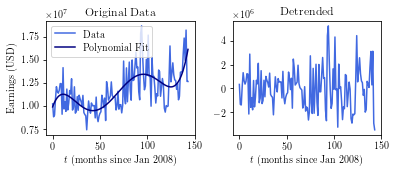

In [7]:
# first, normalize so that the maximum value is 1
detrended_norm = detrended / np.max(np.abs(detrended))

fig, axes = plt.subplots(1, 2, figsize = (5.6, 2.5))
ax1, ax2 = axes
ax1.plot(marvel_comics, color = "royalblue", label = "Data")
ax1.plot(trend(t), color = "navy", label = "Polynomial Fit")
ax1.legend()
ax1.set_title("Original Data")
ax2.set_title("Detrended")

ax2.plot(detrended, color = "royalblue")
for ax in axes:
    ax.set_xlabel("$t$ (months since Jan 2008)")
ax1.set_ylabel("Earnings (USD)")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.tight_layout()
plt.savefig("figures/detrended1.pdf")
plt.show()

Now filter with FT:

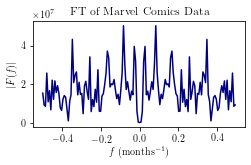

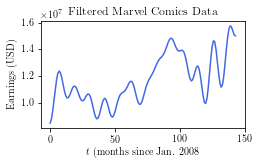

In [16]:
# take FT
FT = np.fft.fft(detrended)

# get freq. axis
freq = np.fft.fftfreq(len(t), 1)

# plot FT
plt.figure(figsize = (3.6, 2.4))
plt.plot(np.fft.fftshift(freq), np.abs(np.fft.fftshift(FT)), color = "navy")
plt.xlabel("$f$ (months$^{-1}$)")
plt.ylabel("$|F(f)|$")
plt.title("FT of Marvel Comics Data")
plt.tight_layout()
plt.savefig("figures/fourier.pdf")
plt.show()

# if freq is greater than 0.1 (in absolute value), then
# set to zero
index = np.abs(freq) > 0.1
filtered_FT = np.copy(FT)
filtered_FT[index] = 0
filtered_detrended = np.fft.ifft(filtered_FT)
filtered = filtered_detrended + trend(t)

plt.figure(figsize = (3.7, 2.4))
plt.plot(filtered, color = "royalblue")
plt.ylabel("Earnings (USD)")
plt.xlabel("$t$ (months since Jan. 2008")
plt.title("Filtered Marvel Comics Data")
plt.tight_layout()
plt.savefig("figures/filtered.pdf")
plt.show()


In [9]:
detrended_norm = detrended / np.max(np.abs(detrended))
mcu_norm = mcu / np.max(np.abs(mcu))

tau = np.arange(-len(mcu_norm) + 1, len(mcu_norm))
c = CC(mcu_norm, detrended_norm)

[]

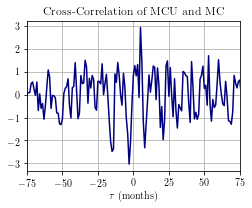

In [10]:
plt.figure(figsize = (3.6, 3))
plt.plot(tau, c, color = "navy")
plt.xlabel("$\\tau$ (months)")
plt.xlim(-75, 75)
plt.title("Cross-Correlation of MCU and MC")
plt.grid()
plt.tight_layout()
plt.savefig("figures/correlation.pdf")
plt.plot()